In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
from sinPINN import Model

c:\Users\jigna\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Burgers Equation:

\begin{align}
\partial_t u_{\theta}(t,z) + u_{\theta}(t,z)\partial_z u_{\theta}(t,z) 
&= \nu\partial_{xx} u_{\theta}(t,z)\\
u_{\theta}(0,z) &= -sin(\pi z)\\
u_{\theta}(t,-1)  &= u_{\theta}(t,1) = 0.
\end{align}

Here times-space is modeled by $(t,z)\in[0,1]\times[-1,1]$, thus $u_{\theta}\colon[0,1]\times[-1,1]\to \R$


In [33]:
class BurgerModel(tf.Module):
    # Models 1D PINN. 
    def __init__(self, layers):

        self.nu = 0.001 / np.pi

        self.layers = layers
        # List of tf.Tensor objects
        self.W = []

        for i in range(len(layers) - 1):
            input_dim = layers[i]
            output_dim = layers[i + 1]

            w = tf.random.normal([output_dim, input_dim], 0, 1, dtype='float64')
            w = tf.Variable(w, trainable=True, name=f'w{i+1}')

            b = tf.zeros([output_dim, 1], dtype='float64')
            b = tf.Variable(b, trainable=True, name=f'b{i+1}')

            self.W.append(w)
            self.W.append(b)

        # Learning rate
        self.rate = 0.001
    
    def evaluate(self, x):
        # Computes u(x; theta)
        a = x
        for i in range(len(self.layers) - 2):
            z = tf.add(tf.matmul(self.W[2*i], a), self.W[2*i + 1])
            a = tf.nn.tanh(z)

        a = tf.add(tf.matmul(self.W[-2], a), self.W[-1])
        return a
     
    def rhs(self, x):
        # Right hand side of the PDE.
        # x: tf.Tensor
        return 0.0

    def get_weights(self):
        return self.W
    
    def set_weights(self, new_weights):
        # Setter for the parameters.
        # Shapes must coincide.
        for i in range(len(new_weights)):
            self.W[i].assign(new_weights[i])
        self.get_weights() 

    def reset_weights(self):
        return None

    ##################### LOSS METHODS ###########################

    def physics_loss(self, data_set):
        # Error given by the PDE over data_set.
        # We compute first and second derivative w.r.t the NN variable.
        # returns tf.Tensor shape=().
        # Every derivative is reshaped to be shape=(1,1).

        l = []
        # Save the first and second derivative evaluated at each
        # (t,z) of datas_set.
        U = []
        U_t = []
        U_z =[]
        U_zz = []

        for x in data_set:
            x = tf.reshape(tf.Variable(x, trainable=False), (2,1))
            with tf.GradientTape() as tape2:
                with tf.GradientTape() as tape1:
                    tape1.watch(x)
                    y = self.evaluate(x)
                u_x = tape1.gradient(y, x)
                tape2.watch(x)
            u_xx = tape2.gradient(u_x, x)

            u = y
            u_t = tf.reshape(u_x[0], (1,1))
            u_z = tf.reshape(u_x[1], (1,1))
            u_zz = tf.reshape(u_xx[1], (1,1))
            U.append(u)
            U_t.append(u_t)
            U_z.append(u_z)
            U_zz.append(u_zz)

            # Save residue evaluated at x.
            aux = tf.add(u_t, tf.matmul(u, u_z))
            l.append(tf.add(aux, tf.matmul(u_zz, [[-self.nu]])))
            
            del tape1, tape2


        l = tf.reshape(l, (1,len(data_set)))
        loss = tf.math.reduce_mean(tf.math.multiply(l, l))
        return loss 



    def boundary_condition(self, boundary_data):
        init, up, down = boundary_data
        M = len(init)
        #return tf.reshape(a, ())
        I = []
        U = []
        D = []
        for i, u, d in zip(init, up, down):
            I.append(tf.subtract(self.evaluate(i), tf.math.sin(i[1])))
            U.append(self.evaluate(u))
            D.append(self.evaluate(d))

        I = tf.reshape(I, (1,M))
        U = tf.reshape(U, (1,M))
        D = tf.reshape(D, (1,M))
        lossI = tf.math.reduce_mean(tf.math.multiply(I,I))
        lossU = tf.math.reduce_mean(tf.math.multiply(U,U))
        lossD = tf.math.reduce_mean(tf.math.multiply(D,D))
        
        return tf.add(tf.add(lossI, lossU),lossD)

    def total_loss(self, data_set, boundary_data):
        # Loss computed from the PDE + loss from training data.
        # returns tf.Tensor shape=()

        return tf.add(self.physics_loss(data_set), self.boundary_condition(boundary_data))

    ##################### TRAINING METHODS ###########################


    def new_weight(self, old_W, gradients):
        # old_W: list of tensors
        # gradients: list of tensors
        # Computes: theta_{k+1} = t_k - \eta\grad L(\theta_k)
        new_W = []
        for w, grad in zip(old_W, gradients):
            aux = w - self.rate * grad
            new_W.append(aux)
        return new_W

    def gradients(self, data_set, boundary_data):
        # Performs one iteration of GD.
        # Since self.trainable_variables is constantly being updated,
        # the gradient is evaluated at different values of weights.
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            target = self.total_loss(data_set, boundary_data)
        gradients = tape.gradient(target, self.trainable_variables)
        return gradients
            
    def update(self, data_set, boundary_data):
        # Performs the update on the weights according to 
        # the gradient descent.
        old_w = self.get_weights()
        gradients = self.gradients(data_set, boundary_data)
        new_W = self.new_weight(old_w, gradients)
        self.set_weights(new_W)
    
    def train(self):
        # Generates a batch at each iteration
        N = 20
        M = 20
        num_iter = 1000

        # For each iteration we generate a new random batch of data.
        for _ in tqdm(range(num_iter)):

            # Data set for the PDE loss.
            T = np.random.uniform(0, 1, N)
            Z = np.random.uniform(-1, 1, N)
            data_set = [[[t], [z]] for t,z in zip(T,Z)]

            # Data set for the boundaty condition.
            boundary_data = []
            init = [[[0],[x]] for x in np.random.uniform(-1,1,M)]
            up = [[[t],[1.0]] for t in np.random.uniform(0,1,M)]
            down = [[[t],[-1.0]] for t in np.random.uniform(0,1,M)]
            boundary_data = [init, up, down]
            
            self.update(data_set, boundary_data)
            
    ##################################################################
    


In [34]:
model = BurgerModel([2,20,20,20,20,20,20,1])

In [35]:
# Creating data_set.
N = 2
T = np.random.uniform(0, 1, N)
Z = np.random.uniform(-1, 1, N)
data_set = [[[t], [z]] for t,z in zip(T,Z)]
data_set[0]

[[0.9983144835559046], [-0.6993173289619445]]

In [36]:
# model.evaluate() test:
model.evaluate(data_set[0])

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-0.46046696]])>

In [37]:
# model.get_weights() test:
for tensor in model.get_weights():
    print('shape: ', tensor.shape, 'name: ', tensor.name)

shape:  (20, 2) name:  w1:0
shape:  (20, 1) name:  b1:0
shape:  (20, 20) name:  w2:0
shape:  (20, 1) name:  b2:0
shape:  (20, 20) name:  w3:0
shape:  (20, 1) name:  b3:0
shape:  (20, 20) name:  w4:0
shape:  (20, 1) name:  b4:0
shape:  (20, 20) name:  w5:0
shape:  (20, 1) name:  b5:0
shape:  (20, 20) name:  w6:0
shape:  (20, 1) name:  b6:0
shape:  (1, 20) name:  w7:0
shape:  (1, 1) name:  b7:0


In [38]:
# physics_loss(data_set) test:
model.physics_loss(data_set)

<tf.Tensor: shape=(), dtype=float64, numpy=3.344826217443172>

In [39]:
# model.train() test:
model.train()

100%|██████████| 1000/1000 [08:51<00:00,  1.88it/s]


In [20]:
model.evaluate([[0], [0]])

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.01352483]])>

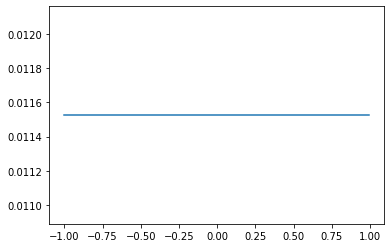

In [42]:
t = 0
x = [[[t], [z]] for z in np.arange(-1,1,0.01)]
y = [model.evaluate(v)[0,0].numpy() for v in x]
plt.plot(np.arange(-1,1,0.01), y)